# Lab 3 - AI - Deep learning for road and vehicle segmentation

**AL5.A.01 - BUT3 - IUT Vannes**

This lab focuses on training a segmentation model using PyTorch to identify and separate roads and vehicles from images. Throughout this notebook, we will cover data loading, data transformation and augmentation, model creation, training, and evaluation.

## Dataset :
https://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/  
(see also http://web4.cs.ucl.ac.uk/staff/g.brostow/MotionSegRecData/)  
Files are [here](http://vis.cs.ucl.ac.uk/Download/G.Brostow/CamVid/) and [here](http://web4.cs.ucl.ac.uk/staff/g.brostow/MotionSegRecData/files/) but we take them from a simplified repo which removes the need to convert all the files : https://github.com/alexgkendall/SegNet-Tutorial/tree/master/CamVid  
  
It is a set of :
- train images + segmentation masks
- validation images + segmentation masks
- test images + segmentation masks  

All images have 320 pixels height and 480 pixels width.

## Part 1 : One-class segmentation
In this part, we focus on single-class segmentation by training a model to recognize and isolate "car" objects from the background. We will start by setting up the data loaders and building a custom dataset class to handle the images and masks.

### Imports

In [ ]:
%pip install -U segmentation-models-pytorch lightning albumentations scikit-learn torchmetrics
!git clone https://github.com/alexgkendall/SegNet-Tutorial ./data --depth=1

import gc
import os

import cv2
import torch
import torchmetrics

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pytorch_lightning.loggers import CSVLogger
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    f1_score,
    PrecisionRecallDisplay,
    precision_recall_curve,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.optim import lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device : {device}")


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.8/225.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.4/291.4 kB 5.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=8608

In [ ]:
DATA_DIR = "./data/CamVid/"

x_train_dir = os.path.join(DATA_DIR, "train")
y_train_dir = os.path.join(DATA_DIR, "trainannot")

x_valid_dir = os.path.join(DATA_DIR, "val")
y_valid_dir = os.path.join(DATA_DIR, "valannot")

x_test_dir = os.path.join(DATA_DIR, "test")
y_test_dir = os.path.join(DATA_DIR, "testannot")


### Dataloader
We create a custom Dataset class to load the CamVid images and masks. The class handles image transformations, such as resizing and converting color spaces, and extracts relevant classes from the mask based on specified class values (in this case, "car"). This class allows seamless integration with the PyTorch DataLoader.


In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation transformations.

    Args:
        images_dir (str) : path to images folder
        masks_dir (str) : path to segmentation masks folder
        class_values (list) : values of classes to extract from segmentation mask
        augmentation (albumentations.Compose) : data transfromation pipeline (ex flip, scale, ...)
    """

    CLASSES = [
        "sky",
        "building",
        "pole",
        "road",
        "pavement",
        "tree",
        "signsymbol",
        "fence",
        "car",
        "pedestrian",
        "bicyclist",
        "unlabelled",
    ]

    def __init__(
        self,
        images_dir,
        masks_dir,
        classes=None,
        augmentation=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation

    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        # BGR-->RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype("float")

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image.transpose(2, 0, 1), mask.transpose(2, 0, 1)

    def __len__(self):
        return len(self.ids)


In [ ]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row"""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        if name == "image":
            plt.imshow(image.transpose(1, 2, 0))
        else:
            plt.imshow(image)
    plt.show()


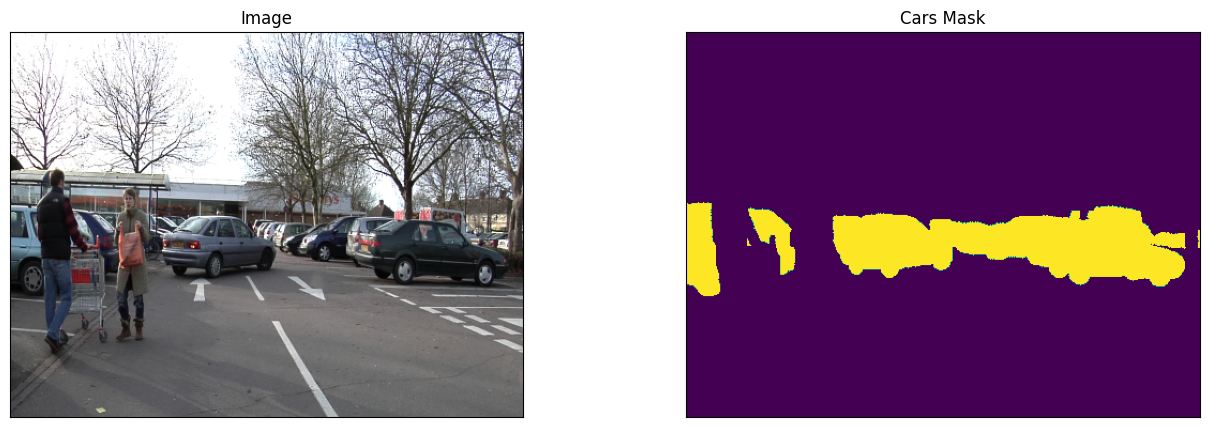

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir, classes=["car"])
# get some sample images
image, mask = dataset[0]
visualize(
    image=image,
    cars_mask=mask.squeeze(),
)


### Augmentations
Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
Since our dataset is very small we will apply a large number of different augmentations:
- horizontal flip
- affine transforms
- perspective transforms
- brightness/contrast/colors manipulations
- image bluring and sharpening
- gaussian noise
- random crops  

All this transforms can be easily applied with Albumentations


In [ ]:
# training set images augmentation
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0
        ),
        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True),
        A.RandomCrop(height=320, width=320, always_apply=True),
        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480),
    ]
    return A.Compose(test_transform)


### Visualize augmented images and masks
Here, we visualize the effect of data augmentations by displaying the same image with various random transformations. This provides insight into the diversity generated by the augmentation pipeline, which helps improve the model's robustness.


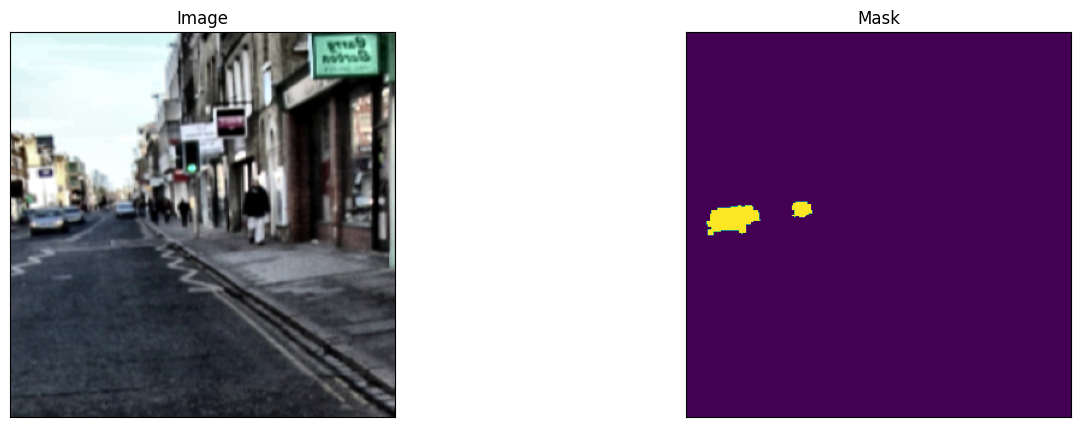

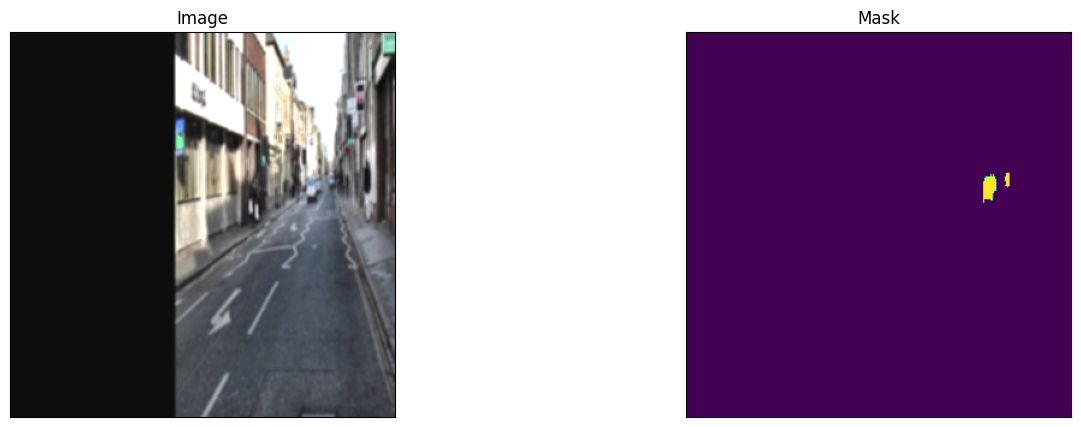

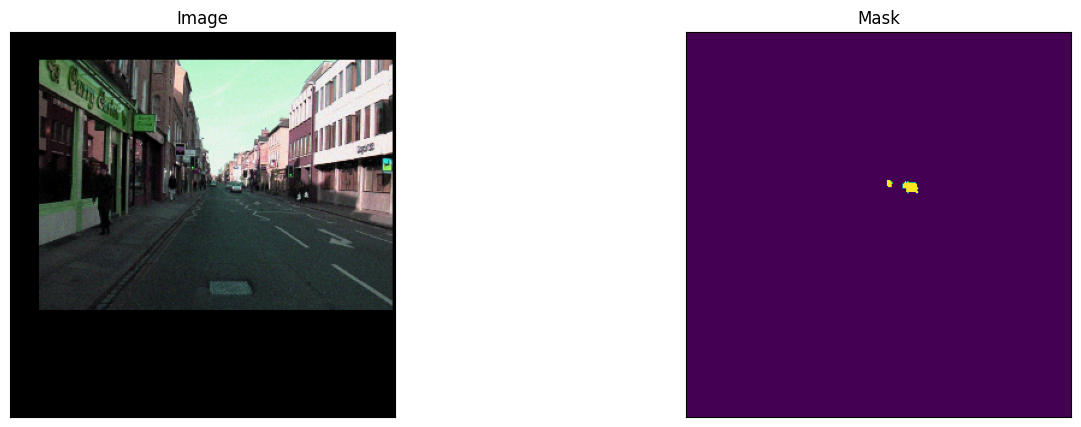

In [ ]:
# Visualize resulted augmented images and masks
augmented_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=["car"],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[3]
    visualize(image=image, mask=mask.squeeze())


### Creating the training and validation sets
We prepare the training, validation, and test datasets for single-class segmentation. Each dataset uses the custom Dataset class defined earlier, and is processed by the respective augmentation functions to ensure consistency across training and validation.


In [ ]:
CLASSES = ["car"]

train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    classes=CLASSES,
)

test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Create model and train
We define a custom segmentation model class using PyTorch Lightning and `segmentation_models_pytorch`. The model architecture, loss function, and optimizer are specified here, allowing for easy customization. This class supports different architectures (like FPN) and backbones (ex ResNeXt50), and includes functions for training, validation, and test steps with appropriate logging.


In [ ]:
# Training hyperparameters
EPOCHS = 20
T_MAX = EPOCHS * len(train_loader)
OUT_CLASSES = 1


In [ ]:
class CamVidModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = image.to(self.mean.device)
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, on_epoch=True, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }


In [ ]:
model = CamVidModel("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES)
model.to(device)


CamVidModel(
  (model): FPN(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

### Training
We set up the PyTorch Lightning Trainer to handle the training loop. The model is trained over multiple epochs, with metrics logged at each step. The validation dataset is evaluated periodically to monitor model performance and prevent overfitting.


In [ ]:
csv_logger = CSVLogger(save_dir="logs/", name="model_1_logs")

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    logger=csv_logger,
    log_every_n_steps=1,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
)

trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 25.6 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.352   Total estimated model params size (MB)
210       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


### Validation and test metrics
After training, we evaluate the model on the validation and test datasets. These metrics provide an initial indication of the model's performance on unseen data and help validate the effectiveness of the training process.


In [ ]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_loader, verbose=False)
print(valid_metrics)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_per_image_iou': 0.6472662687301636, 'valid_dataset_iou': 0.8119110465049744}]


In [ ]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
print(test_metrics)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_per_image_iou': 0.6724201440811157, 'test_dataset_iou': 0.7940330505371094}]


### Result visualization
We visualize the model's predictions by comparing the ground truth and predicted segmentation masks on a sample of test images. This gives a qualitative view of the model's performance, showing how well it distinguishes the target class (cars) from the background.


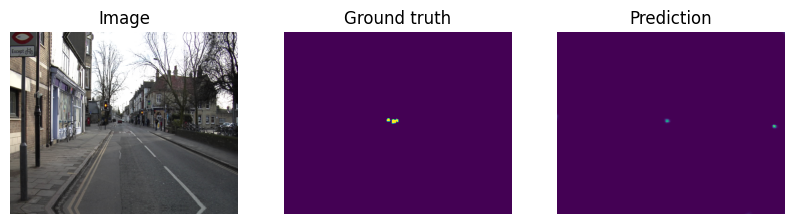

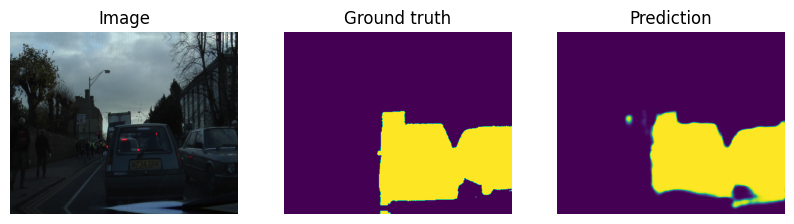

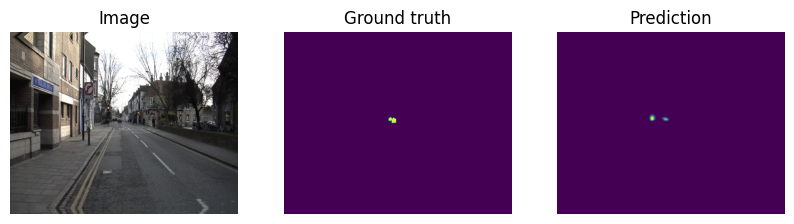

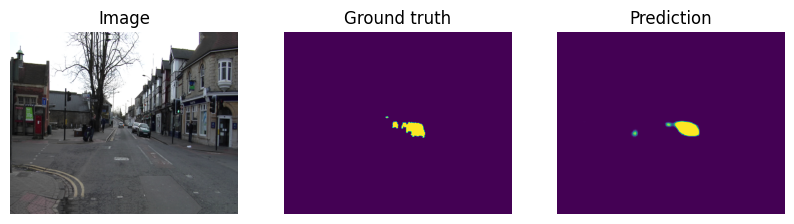

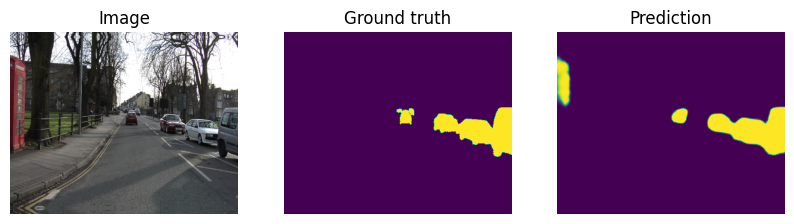

In [ ]:
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

with torch.no_grad():
    model.eval()
    logits = model(images)

pr_masks = logits.sigmoid()

for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    # Number of samples visualized
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.cpu().numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.cpu().numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.cpu().numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break


In [ ]:
# Fonction pour visualiser les métriques du modèle de segmentation
def visualize_metrics(y_true, y_pred, y_scores=None, num_classes=1, class_names=None):
    # Ensure y_true and y_pred are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Confusion matrix
    cm = confusion_matrix(
        y_true.flatten(), y_pred.flatten(), labels=range(num_classes), normalize="true"
    )

    if class_names is None:
        class_names = [str(i) for i in range(num_classes)]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format=".2f", xticks_rotation="vertical")
    plt.title("Confusion Matrix")
    plt.show()

    if num_classes == 1:
        # Binary (single-class) segmentation
        avg_precision = precision_score(
            y_true.flatten(), y_pred.flatten(), zero_division=0
        )
        avg_recall = recall_score(y_true.flatten(), y_pred.flatten(), zero_division=0)
        avg_f1 = f1_score(y_true.flatten(), y_pred.flatten(), zero_division=0)

        # Precision-Recall curve
        if y_scores is not None:
            precisions, recalls, thresholds = precision_recall_curve(
                y_true.flatten(), y_scores
            )
            f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

            # Precision-Recall Curve
            plt.figure(figsize=(8, 6))
            plt.plot(recalls, precisions, label="Precision-Recall Curve")
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title("Precision-Recall Curve")
            plt.legend()
            plt.show()

            # F1 Score vs Threshold
            plt.figure(figsize=(8, 6))
            plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
            plt.xlabel("Threshold")
            plt.ylabel("F1 Score")
            plt.title("F1 Score vs. Threshold")
            plt.legend()
            plt.show()
        else:
            print(
                "Predicted probabilities (y_scores) are required to plot PR and F1 curves."
            )
    else:
        # Multi-class segmentation
        avg_precision = precision_score(
            y_true.flatten(), y_pred.flatten(), average="weighted", zero_division=0
        )
        avg_recall = recall_score(
            y_true.flatten(), y_pred.flatten(), average="weighted", zero_division=0
        )
        avg_f1 = f1_score(
            y_true.flatten(), y_pred.flatten(), average="weighted", zero_division=0
        )

        # Compute per-class metrics
        class_precisions = precision_score(
            y_true.flatten(),
            y_pred.flatten(),
            labels=range(num_classes),
            average=None,
            zero_division=0,
        )
        class_recalls = recall_score(
            y_true.flatten(),
            y_pred.flatten(),
            labels=range(num_classes),
            average=None,
            zero_division=0,
        )
        class_f1_scores = f1_score(
            y_true.flatten(),
            y_pred.flatten(),
            labels=range(num_classes),
            average=None,
            zero_division=0,
        )

        # Display per-class metrics
        for i in range(num_classes):
            print(
                f"Class {i} : Precision : {class_precisions[i]:.3f}, Recall : {class_recalls[i]:.3f}, F1 Score : {class_f1_scores[i]:.3f}"
            )

        del cm, disp
        torch.cuda.empty_cache()
        gc.collect()

        # Precision-Recall curves per class
        if y_scores is not None:
            # Binarize the true labels for each class
            y_true_binarized = label_binarize(
                y_true.flatten(), classes=range(num_classes)
            )
            if y_scores.shape[1] != num_classes:
                raise ValueError("y_scores should have shape [n_samples, num_classes]")
            # Plot PR curves for each class
            plt.figure(figsize=(12, 8))
            for i in range(num_classes):
                precision, recall, _ = precision_recall_curve(
                    y_true_binarized[:, i], y_scores[:, i]
                )
                plt.plot(recall, precision, lw=2, label=f"Class {i}")
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title("Precision-Recall Curve for Each Class")
            plt.legend(loc="best")
            plt.show()
        else:
            print(
                "Predicted probabilities (y_scores) are required to plot PR curves for multi-class classification."
            )

    print(f"\nAverage Precision : {avg_precision:.3f}")
    print(f"Average Recall : {avg_recall:.3f}")
    print(f"Average F1 Score : {avg_f1:.3f}")

    return avg_precision, avg_recall, avg_f1


# Fonction pour générer et afficher les métriques
def evaluate_model_metrics(dataloader, model, num_classes=1, class_names=None):
    y_true_list, y_pred_list, y_score_list = [], [], []

    # Prediction and collection of true values
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        with torch.no_grad():
            logits = model(images)
            if num_classes == 1:
                pr_masks = logits.sigmoid()
                y_scores = pr_masks.cpu().numpy().flatten()
                y_pred = (pr_masks > 0.5).float().cpu().numpy().flatten()
            else:
                pr_masks = logits.softmax(dim=1)
                y_scores = (
                    pr_masks.cpu().numpy()
                )  # Shape: [batch_size, num_classes, H, W]
                y_scores = y_scores.transpose(0, 2, 3, 1).reshape(-1, num_classes)
                y_pred = pr_masks.argmax(dim=1).cpu().numpy().flatten()
            y_true = masks.cpu().numpy().flatten()
            y_true_list.append(y_true)
            y_pred_list.append(y_pred)
            y_score_list.append(y_scores)

    del images, masks, logits, pr_masks
    torch.cuda.empty_cache()
    gc.collect()

    # Concatenate predictions and labels
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    y_scores = np.concatenate(y_score_list)

    # Visualize metrics and get returned metrics
    avg_precision, avg_recall, avg_f1 = visualize_metrics(
        y_true, y_pred, y_scores, num_classes=num_classes
    )

    # Return the metrics
    return avg_precision, avg_recall, avg_f1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


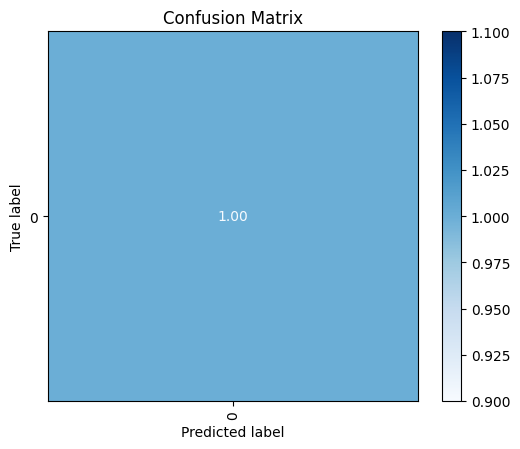

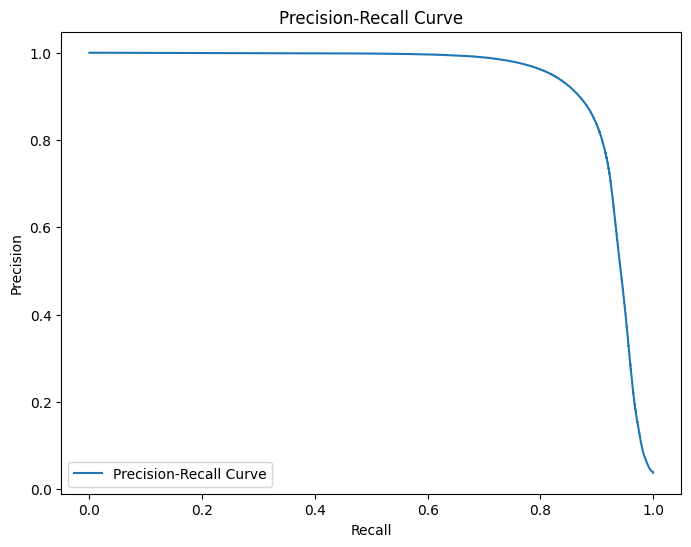

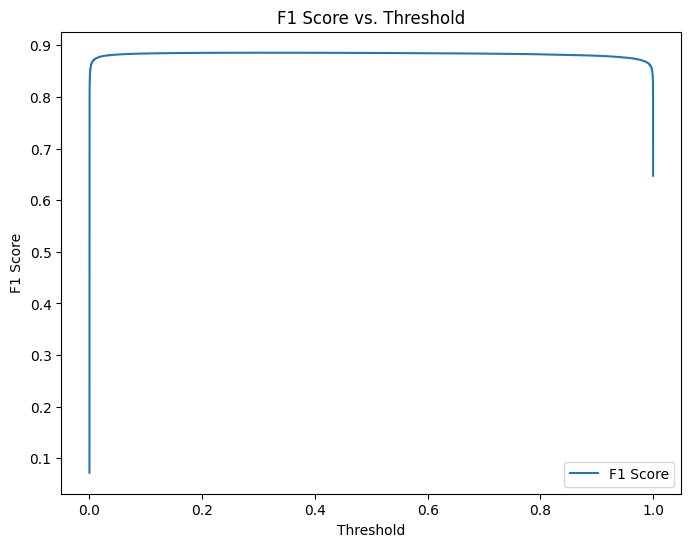


Average Precision : 0.928
Average Recall : 0.846
Average F1 Score : 0.885


In [ ]:
avg_precision_model1, avg_recall_model1, avg_f1_model1 = evaluate_model_metrics(
    test_loader, model, num_classes=OUT_CLASSES, class_names=CLASSES
)


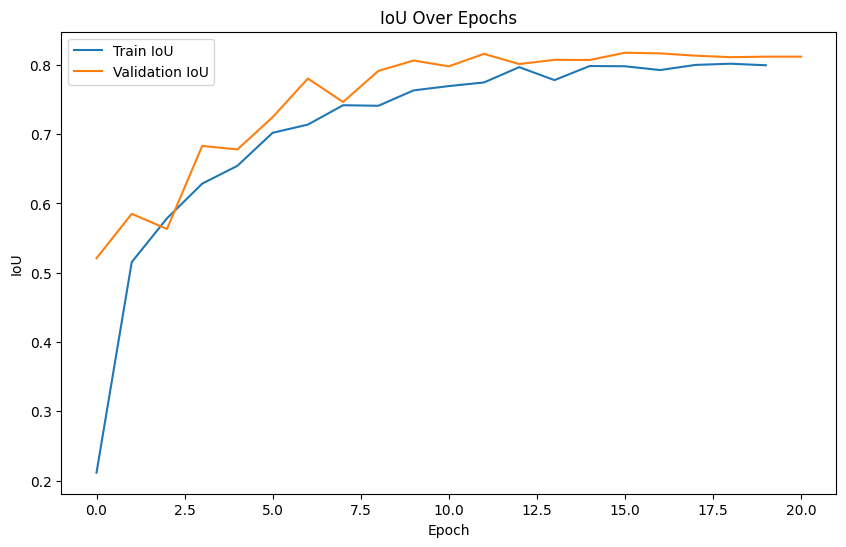

In [ ]:
# Load the logged metrics
metrics_df = pd.read_csv(f"{csv_logger.log_dir}/metrics.csv")

# Filter out the rows without 'step' information (if any)
metrics_df = metrics_df.dropna(subset=["step"])

# Extract epoch numbers and IoU values
epochs = metrics_df["epoch"].unique()

train_iou = metrics_df.groupby("epoch")["train_dataset_iou"].mean()
val_iou = metrics_df.groupby("epoch")["valid_dataset_iou"].mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_iou, label="Train IoU")
plt.plot(epochs, val_iou, label="Validation IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("IoU Over Epochs")
plt.legend()
plt.show()


---

## Part 2 : Multi-class segmentation
In this section, we extend the model to perform multi-class segmentation, identifying not only cars but also other objects in the environment, such as roads, buildings, pedestrians, etc. This section adapts the previous dataset, augmentations, and model setup for multiple classes.  
Functions and others have a `2` appended to their name to not conflict in case we want to run previous cells.

### Dataloader
A new Dataset class is implemented for multi-class segmentation, allowing us to specify multiple classes and apply a dynamic remapping to distinguish different object types in the segmentation masks.


In [ ]:
class Dataset2(BaseDataset):
    CLASSES = [
        "sky",
        "building",
        "pole",
        "road",
        "pavement",
        "tree",
        "signsymbol",
        "fence",
        "car",
        "pedestrian",
        "bicyclist",
        "unlabelled",
    ]

    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # Always map background ('unlabelled') to 0
        self.background_class = self.CLASSES.index("unlabelled")

        # If specific classes are provided, map them dynamically
        if classes:
            self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        else:
            self.class_values = list(range(len(self.CLASSES)))  # Default to all classes

        # Create a remapping dictionary: class value in dataset -> new index (0, 1, 2, ...)
        # Background will always be 0, other classes will be remapped starting from 1.
        self.class_map = {self.background_class: 0}
        self.class_map.update(
            {
                v: i + 1
                for i, v in enumerate(self.class_values)
                if v != self.background_class
            }
        )

        self.augmentation = augmentation

    def __getitem__(self, i):
        # Read the image
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Read the mask in grayscale mode
        mask = cv2.imread(self.masks_fps[i], 0)

        # Create a blank mask to remap the class values
        mask_remap = np.zeros_like(mask)

        # Remap the mask according to the dynamically created class map
        for class_value, new_value in self.class_map.items():
            mask_remap[mask == class_value] = new_value

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask_remap)
            image, mask_remap = sample["image"], sample["mask"]
        image = image.transpose(2, 0, 1)
        return image, mask_remap

    def __len__(self):
        return len(self.ids)


### Visualize augmented images and masks
We visualize the multi-class augmented images and masks to ensure the transformations are correctly applied across multiple classes, and that the augmentations provide the desired diversity in the dataset.


In [ ]:
def visualize2(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())

        # If it's an image, plot it as RGB
        if name == "image":
            # Convert CHW to HWC for plotting
            image = image.transpose(1, 2, 0)
            plt.imshow(image)
        else:
            plt.imshow(image, cmap="tab20")
    plt.show()


Mask shape: (360, 480)


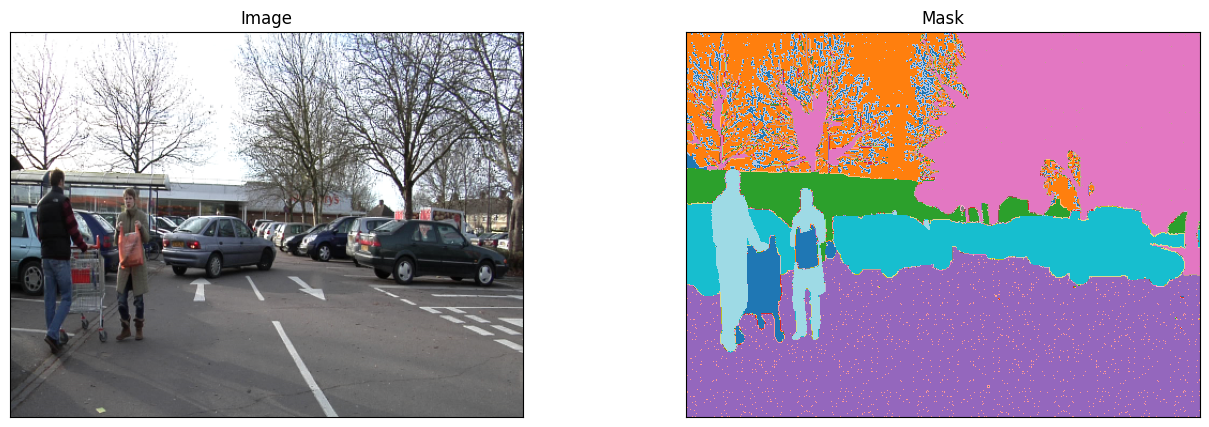

In [ ]:
dataset2 = Dataset2(x_train_dir, y_train_dir)
image2, mask2 = dataset2[0]
print(f"Mask shape: {mask2.shape}")
visualize2(image=image2, mask=mask2)


### Augmentations


Mask shape: (320, 320)
[ 0  1  2  3  4  5  7  8  9 10 11]


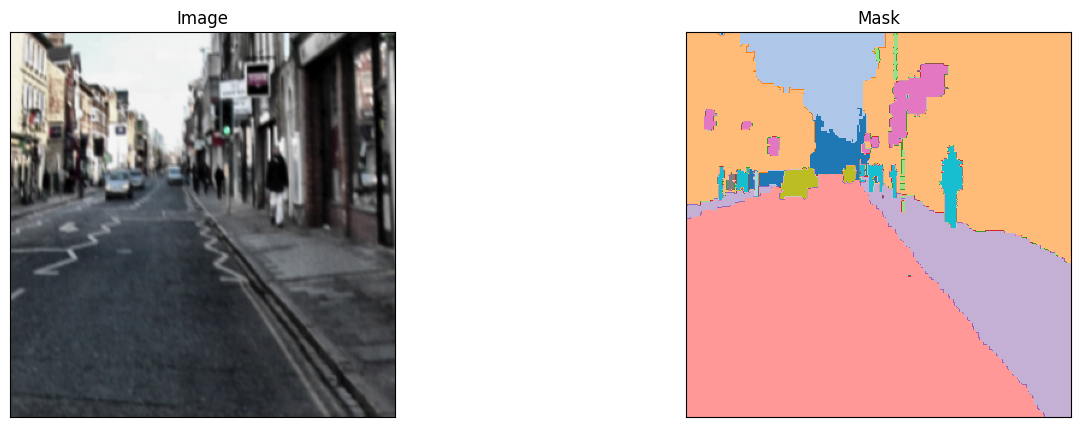

Mask shape: (320, 320)
[ 0  1  2  3  4  5  7  8  9 10 11]


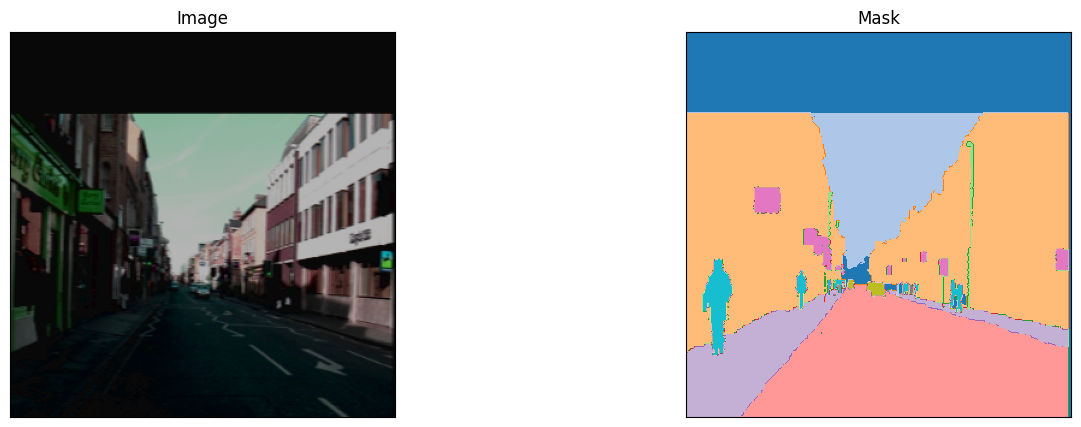

Mask shape: (320, 320)
[ 0  1  2  3  4  5  7  8  9 10 11]


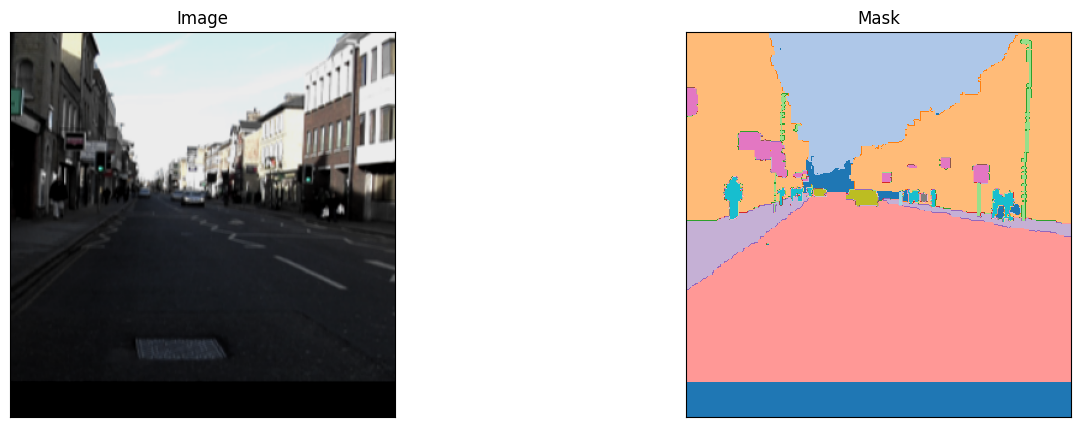

In [ ]:
# Visualize resulted augmented images and masks
augmented_dataset2 = Dataset2(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
)

# Visualizing the same image with different random transforms
for i in range(3):
    image2, mask2 = augmented_dataset2[3]
    print(f"Mask shape: {mask2.shape}")
    print(np.unique(mask2))
    visualize2(image=image2, mask=mask2)


### Creating the training and validation sets
The training, validation, and test sets are created for multi-class segmentation. Each dataset applies the custom multi-class Dataset class with the augmentation pipeline.


In [ ]:
train_dataset2 = Dataset2(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
)

valid_dataset2 = Dataset2(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
)

test_dataset2 = Dataset2(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
)

# Change to > 0 if not on Windows machine
train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True, num_workers=0)
valid_loader2 = DataLoader(valid_dataset2, batch_size=32, shuffle=False, num_workers=0)
test_loader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False, num_workers=0)


### Create model and train
A new model class is defined for multi-class segmentation, with minor adjustments to handle multiple classes (including the background). The loss function is modified to handle multiple classes, and we specify the number of output classes to match the dataset. The training steps, validation, and test steps are similar to the single-class setup but adapted for multiple classes.


In [ ]:
# Training hyperparameters
EPOCHS2 = 50
T_MAX2 = EPOCHS2 * len(train_loader2)
# Always include the background as a class
OUT_CLASSES2 = len(train_dataset2.CLASSES)


In [ ]:
class CamVidModel2(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )

        # Preprocessing parameters for image normalization
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.number_of_classes = out_classes
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # Loss function for multi-class segmentation
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)

        # Step metrics tracking
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # Normalize image
        image = image.to(self.mean.device)
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch

        # Ensure that image dimensions are correct
        assert image.ndim == 4  # [batch_size, channels, H, W]

        # Ensure the mask is a long (index) tensor
        mask = mask.long()

        # Mask shape
        assert mask.ndim == 3  # [batch_size, H, W]

        # Predict mask logits
        logits_mask = self.forward(image)

        assert (
            logits_mask.shape[1] == self.number_of_classes
        )  # [batch_size, number_of_classes, H, W]

        # Ensure the logits mask is contiguous
        logits_mask = logits_mask.contiguous()

        # Compute loss using multi-class Dice loss (pass original mask, not one-hot encoded)
        loss = self.loss_fn(logits_mask, mask)

        # Apply softmax to get probabilities for multi-class segmentation
        prob_mask = logits_mask.softmax(dim=1)

        # Convert probabilities to predicted class labels
        pred_mask = prob_mask.argmax(dim=1)

        # Compute true positives, false positives, false negatives, and true negatives
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask, mask, mode="multiclass", num_classes=self.number_of_classes
        )

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # Aggregate step metrics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # Per-image IoU and dataset IoU calculations
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, on_epoch=True, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }


In [ ]:
model2 = CamVidModel2("FPN", "resnext50_32x4d", in_channels=3, out_classes=OUT_CLASSES2)
model2 = model2.to(device)


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 285MB/s]


### Training
We use the PyTorch Lightning Trainer to train the multi-class model. The model's metrics, including multi-class IoU, are logged at each step to monitor training progress and validation performance.


In [ ]:
csv_logger2 = CSVLogger(save_dir="logs/", name="model_2_logs")

trainer2 = pl.Trainer(
    max_epochs=EPOCHS2,
    logger=csv_logger2,
    log_every_n_steps=1,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
)

trainer2.fit(
    model2,
    train_dataloaders=train_loader2,
    val_dataloaders=valid_loader2,
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 25.6 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.357   Total estimated model params size (MB)
210       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


### Validation and test metrics
After training, we evaluate the model's performance on the validation and test sets for multi-class segmentation. This step provides a quantitative evaluation of the model's ability to segment different classes accurately.


In [ ]:
# run validation dataset
valid_metrics2 = trainer2.validate(model2, dataloaders=valid_loader2, verbose=False)
print(valid_metrics2)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_per_image_iou': 0.8383986949920654, 'valid_dataset_iou': 0.8378542065620422}]


In [ ]:
# run test dataset
test_metrics2 = trainer2.test(model2, dataloaders=test_loader2, verbose=False)
print(test_metrics2)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_per_image_iou': 0.761941134929657, 'test_dataset_iou': 0.7591032385826111}]


### Result visualization
We visualize the model's predictions for multi-class segmentation, comparing the ground truth and predicted masks across several classes. This step gives a qualitative assessment of how well the model identifies and separates each class within the images.


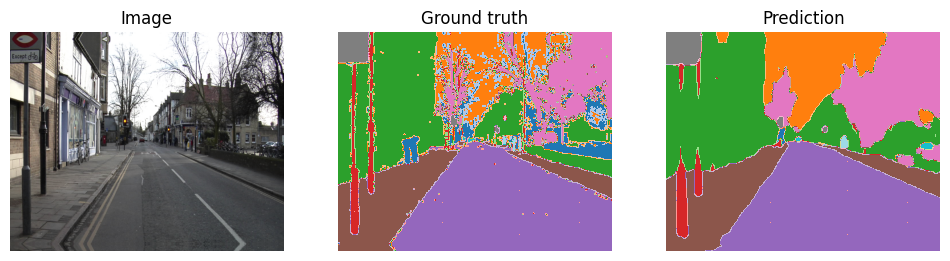

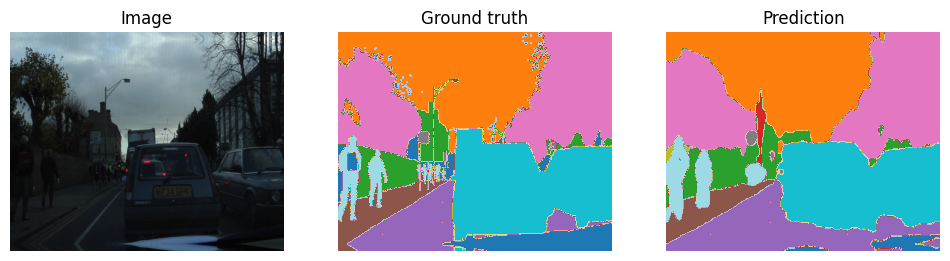

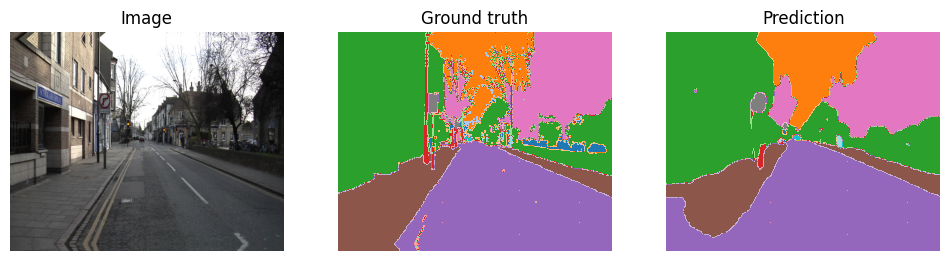

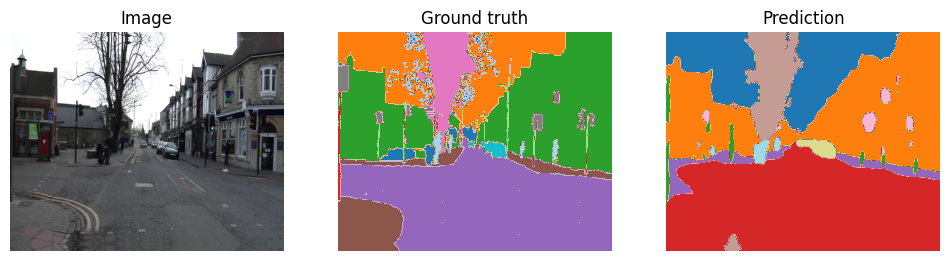

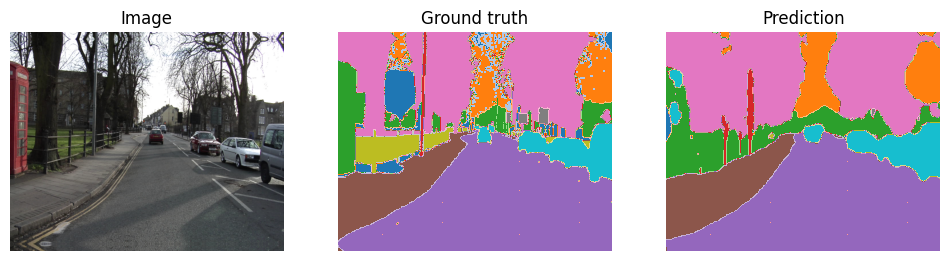

In [ ]:
# Fetch a batch from the test loader
images2, masks2 = next(iter(test_loader2))
images2, masks2 = images2.to(device), masks2.to(device)

# Switch the model to evaluation mode
with torch.no_grad():
    model2.eval()
    logits2 = model2(images2)  # Get raw logits from the model

# Apply softmax to get class probabilities
# Shape: [batch_size, num_classes, H, W]

pr_masks2 = logits2.softmax(dim=1)
# Convert class probabilities to predicted class labels
pr_masks2 = pr_masks2.argmax(dim=1)  # Shape: [batch_size, H, W]

# Visualize a few samples (image, ground truth mask, and predicted mask)
for idx2, (image2, gt_mask2, pr_mask2) in enumerate(zip(images2, masks2, pr_masks2)):
    if idx2 <= 4:  # Visualize first 5 samples
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(
            image2.cpu().numpy().transpose(1, 2, 0)
        )  # Convert CHW to HWC for plotting
        plt.title("Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask2.cpu().numpy(), cmap="tab20")  # Visualize ground truth mask
        plt.title("Ground truth")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask2.cpu().numpy(), cmap="tab20")  # Visualize predicted mask
        plt.title("Prediction")
        plt.axis("off")

        # Show the figure
        plt.show()
    else:
        break


In [ ]:
# Clean previous unused content from the memory (ONLY ON COLAB)
del (
    model,
    A,
    Dataset,
    visualize,
    dataset,
    get_training_augmentation,
    get_validation_augmentation,
    augmented_dataset,
    CamVidModel,
    trainer,
    csv_logger,
    images,
    masks,
    images2,
    masks2,
    logits,
    logits2,
    pr_masks,
    pr_masks2,
    test_loader,
)

torch.cuda.empty_cache()
gc.collect()


21516

In [ ]:
def visualize_metrics2(y_true, y_pred, y_scores=None, num_classes=1, class_names=None):
    # Ensure y_true and y_pred are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Normalize the confusion matrix
    cm = confusion_matrix(
        y_true.flatten(),
        y_pred.flatten(),
        labels=range(num_classes),
        normalize="true",  # Normalize over the true labels (rows)
    )

    # If class names are not provided, use class indices
    if class_names is None:
        class_names = [str(i) for i in range(num_classes)]

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format=".2f", xticks_rotation="vertical")
    plt.title("Normalized Confusion Matrix")
    plt.show()

    # Compute average metrics
    avg_precision = precision_score(
        y_true.flatten(), y_pred.flatten(), average="weighted", zero_division=0
    )
    avg_recall = recall_score(
        y_true.flatten(), y_pred.flatten(), average="weighted", zero_division=0
    )
    avg_f1 = f1_score(
        y_true.flatten(), y_pred.flatten(), average="weighted", zero_division=0
    )

    # Compute per-class metrics
    class_precisions = precision_score(
        y_true.flatten(),
        y_pred.flatten(),
        labels=range(num_classes),
        average=None,
        zero_division=0,
    )
    class_recalls = recall_score(
        y_true.flatten(),
        y_pred.flatten(),
        labels=range(num_classes),
        average=None,
        zero_division=0,
    )
    class_f1_scores = f1_score(
        y_true.flatten(),
        y_pred.flatten(),
        labels=range(num_classes),
        average=None,
        zero_division=0,
    )

    # Display per-class metrics
    print("Per-Class Metrics:")
    for i in range(num_classes):
        print(
            f"Class '{class_names[i]}': Precision: {class_precisions[i]:.3f}, "
            f"Recall: {class_recalls[i]:.3f}, F1 Score: {class_f1_scores[i]:.3f}"
        )

    # Clear variables to free memory
    del cm, disp
    gc.collect()

    # Precision-Recall curves per class (using sampled data)
    if y_scores is not None:
        # Binarize the true labels for each class
        y_true_binarized = label_binarize(y_true.flatten(), classes=range(num_classes))
        if y_scores.shape[1] != num_classes:
            raise ValueError("y_scores should have shape [n_samples, num_classes]")

        # Plot PR curves for each class (sampling to reduce memory usage)
        plt.figure(figsize=(12, 8))
        for i in range(num_classes):
            precision, recall, _ = precision_recall_curve(
                y_true_binarized[:, i], y_scores[:, i]
            )
            plt.plot(recall, precision, lw=2, label=f"Class {class_names[i]}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve for Each Class")
        plt.legend(loc="best")
        plt.show()
    else:
        print(
            "Predicted probabilities (y_scores) are required to plot PR curves for multi-class classification."
        )

    print(f"\nAverage Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1 Score: {avg_f1:.3f}")

    # Clear variables to free memory
    del y_true, y_pred, y_scores
    gc.collect()

    return avg_precision, avg_recall, avg_f1


def evaluate_model_metrics2(
    dataloader, model, num_classes=1, class_names=None, sample_fraction=0.01
):
    y_true_sample_list, y_pred_sample_list, y_score_sample_list = [], [], []

    # Initialize accumulators for metrics
    total_precision = 0.0
    total_recall = 0.0
    total_f1 = 0.0
    num_batches = 0

    # Prediction and collection of true values
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        with torch.no_grad():
            logits = model(images)
            if num_classes == 1:
                pr_masks = logits.sigmoid()
                y_scores = pr_masks.cpu().numpy()
                y_pred = (pr_masks > 0.5).float().cpu().numpy()
            else:
                pr_masks = logits.softmax(dim=1)
                y_scores = (
                    pr_masks.cpu().numpy()
                )  # Shape: [batch_size, num_classes, H, W]
                y_pred = pr_masks.argmax(dim=1).cpu().numpy()
            y_true = masks.cpu().numpy()

        # Flatten arrays
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
        if num_classes == 1:
            y_scores_flat = y_scores.flatten()
        else:
            y_scores_flat = y_scores.transpose(0, 2, 3, 1).reshape(-1, num_classes)

        # Compute batch metrics
        batch_precision = precision_score(
            y_true_flat, y_pred_flat, average="weighted", zero_division=0
        )
        batch_recall = recall_score(
            y_true_flat, y_pred_flat, average="weighted", zero_division=0
        )
        batch_f1 = f1_score(
            y_true_flat, y_pred_flat, average="weighted", zero_division=0
        )

        # Accumulate metrics
        total_precision += batch_precision
        total_recall += batch_recall
        total_f1 += batch_f1
        num_batches += 1

        # Sample data for visualization
        n_samples = int(len(y_true_flat) * sample_fraction)
        if n_samples > 0:
            indices = np.random.choice(len(y_true_flat), n_samples, replace=False)
            y_true_sample_list.append(y_true_flat[indices])
            y_pred_sample_list.append(y_pred_flat[indices])
            y_score_sample_list.append(y_scores_flat[indices])

        # Clear variables to free memory
        del (
            images,
            masks,
            logits,
            pr_masks,
            y_scores,
            y_pred,
            y_true,
            y_true_flat,
            y_pred_flat,
            y_scores_flat,
        )
        torch.cuda.empty_cache()
        gc.collect()

    # Compute average metrics over all batches
    avg_precision = total_precision / num_batches
    avg_recall = total_recall / num_batches
    avg_f1 = total_f1 / num_batches

    print(f"\nAverage Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1 Score: {avg_f1:.3f}")

    # Concatenate sampled predictions and labels for visualization
    if y_true_sample_list:
        y_true_sample = np.concatenate(y_true_sample_list)
        y_pred_sample = np.concatenate(y_pred_sample_list)
        y_score_sample = np.concatenate(y_score_sample_list)
    else:
        print(
            "No samples collected for visualization. Adjust 'sample_fraction' if needed."
        )
        return avg_precision, avg_recall, avg_f1

    # Visualize metrics
    avg_precision, avg_recall, avg_f1 = visualize_metrics2(
        y_true_sample,
        y_pred_sample,
        y_scores=y_score_sample,
        num_classes=num_classes,
        class_names=class_names,
    )

    # Return the metrics
    return avg_precision, avg_recall, avg_f1



Average Precision: 0.861
Average Recall: 0.863
Average F1 Score: 0.852


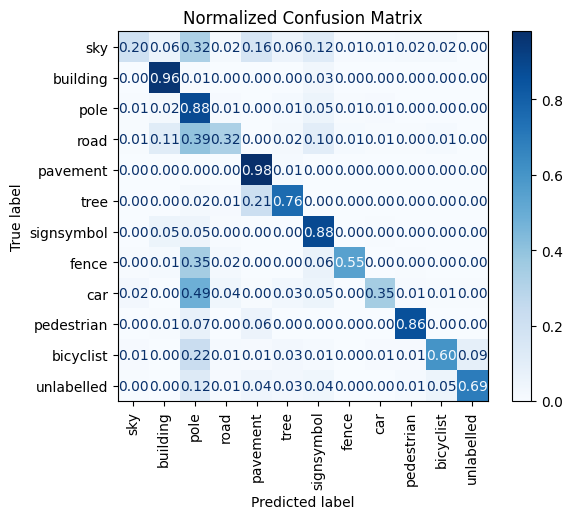

Per-Class Metrics:
Class 'sky': Precision: 0.791, Recall: 0.198, F1 Score: 0.317
Class 'building': Precision: 0.925, Recall: 0.957, F1 Score: 0.941
Class 'pole': Precision: 0.841, Recall: 0.880, F1 Score: 0.860
Class 'road': Precision: 0.379, Recall: 0.324, F1 Score: 0.349
Class 'pavement': Precision: 0.901, Recall: 0.980, F1 Score: 0.939
Class 'tree': Precision: 0.874, Recall: 0.757, F1 Score: 0.811
Class 'signsymbol': Precision: 0.793, Recall: 0.881, F1 Score: 0.835
Class 'fence': Precision: 0.661, Recall: 0.545, F1 Score: 0.598
Class 'car': Precision: 0.521, Recall: 0.348, F1 Score: 0.418
Class 'pedestrian': Precision: 0.924, Recall: 0.859, F1 Score: 0.890
Class 'bicyclist': Precision: 0.607, Recall: 0.604, F1 Score: 0.606
Class 'unlabelled': Precision: 0.549, Recall: 0.689, F1 Score: 0.611


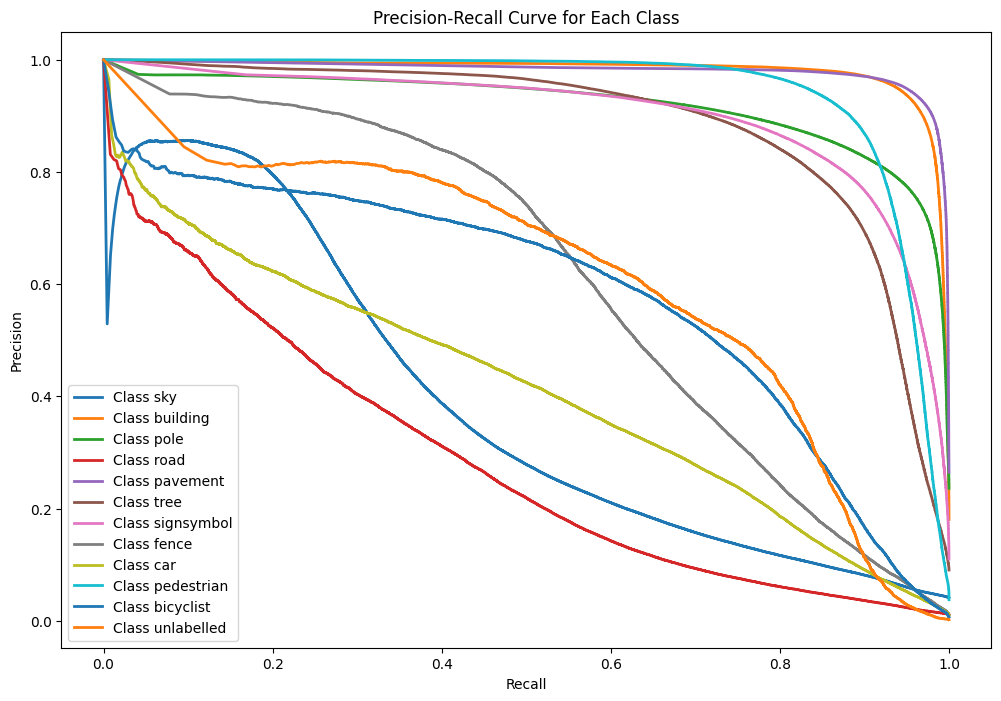


Average Precision: 0.859
Average Recall: 0.863
Average F1 Score: 0.852


In [ ]:
# Adjust sample_fraction to control the amount of data used for visualization (avoids Colab crashing)
sample_fraction = 0.1  # Uses 10% of the data for visualization

avg_precision_model2, avg_recall_model2, avg_f1_model2 = evaluate_model_metrics2(
    test_loader2,
    model2,
    num_classes=OUT_CLASSES2,
    class_names=train_dataset2.CLASSES,
    sample_fraction=sample_fraction,
)


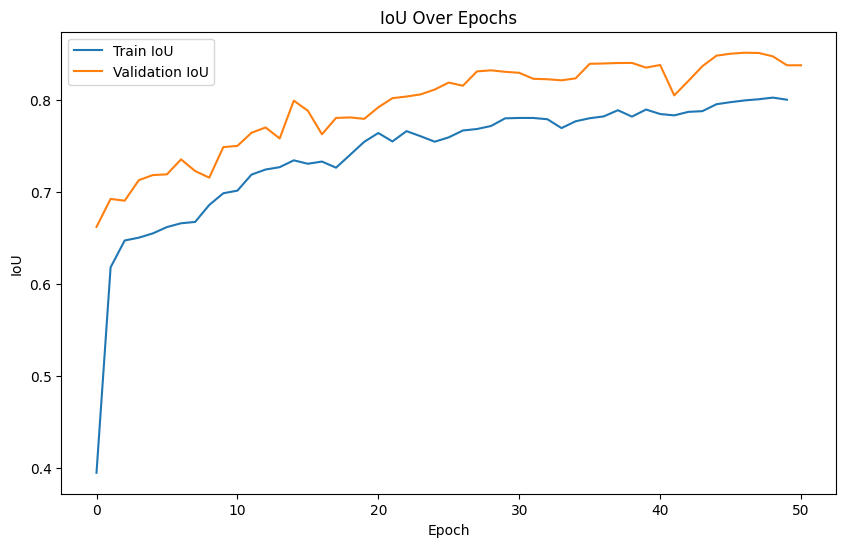

In [ ]:
# Load the logged metrics
metrics_df2 = pd.read_csv(f"{csv_logger2.log_dir}/metrics.csv")

# Filter out the rows without 'step' information (if any)
metrics_df2 = metrics_df2.dropna(subset=["step"])

# Extract epoch numbers and IoU values
epochs2 = metrics_df2["epoch"].unique()

train_iou2 = metrics_df2.groupby("epoch")["train_dataset_iou"].mean()
val_iou2 = metrics_df2.groupby("epoch")["valid_dataset_iou"].mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs2, train_iou2, label="Train IoU")
plt.plot(epochs2, val_iou2, label="Validation IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("IoU Over Epochs")
plt.legend()
plt.show()


---

# Conclusion


This lab demonstrated the process of developing a segmentation model using PyTorch, covering both single-class and multi-class segmentation tasks. For single-class segmentation, the model effectively isolated the "car" class, achieving high precision and recall for that class. Multi-class segmentation introduced additional challenges due to the increased complexity of distinguishing multiple objects in urban scenes.

In terms of performance, the single-class model generally achieved better precision and recall for its specific target class compared to the multi-class model. However, the multi-class model's performance was fairly robust, with acceptable IoU scores for most classes, despite the increased difficulty of segmenting various objects with similar characteristics.

By comparing metrics such as F1-score, IoU, and precision-recall across both models, we observed that single-class segmentation offers higher accuracy for specific tasks but lacks flexibility. In contrast, the multi-class model, while slightly less precise for individual objects, provides a broader understanding of the entire scene. This balance between precision and flexibility highlights the trade-offs that should be considered when choosing a segmentation approach for specific applications, especially in autonomous driving and real-time applications where both accuracy and adaptability are essential.

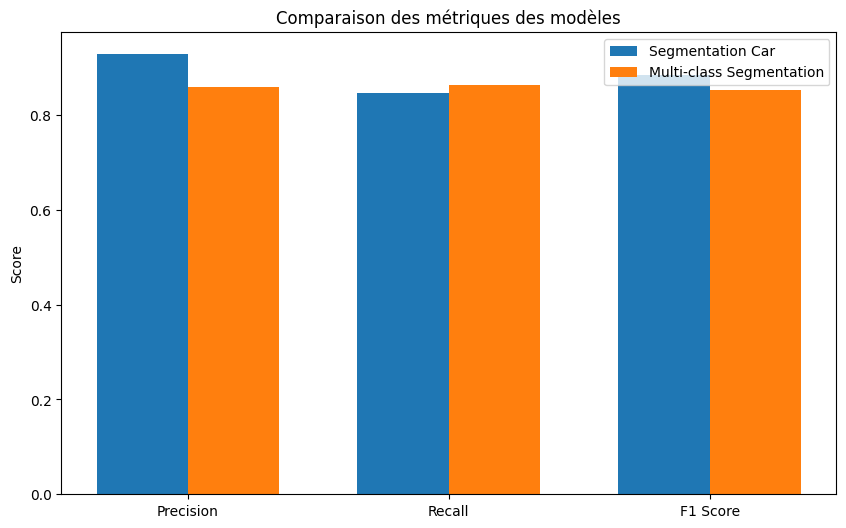

In [ ]:
gc.collect()


# Comparaison finale des métriques des deux modèles
def compare_models_metrics(
    model1_metrics, model2_metrics, model1_name="Model 1", model2_name="Model 2"
):
    # Extraire les scores pour la comparaison
    metrics = ["Precision", "Recall", "F1 Score"]
    model1_scores = [
        model1_metrics["Average Precision"],
        model1_metrics["Average Recall"],
        model1_metrics["Average F1 Score"],
    ]
    model2_scores = [
        model2_metrics["Average Precision"],
        model2_metrics["Average Recall"],
        model2_metrics["Average F1 Score"],
    ]

    # Graphique comparatif
    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width / 2, model1_scores, width, label=model1_name)
    ax.bar(x + width / 2, model2_scores, width, label=model2_name)

    ax.set_ylabel("Score")
    ax.set_title("Comparaison des métriques des modèles")
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    plt.show()


# Exécution de la comparaison
compare_models_metrics(
    model1_metrics={
        "Average Precision": avg_precision_model1,
        "Average Recall": avg_recall_model1,
        "Average F1 Score": avg_f1_model1,
    },
    model2_metrics={
        "Average Precision": avg_precision_model2,
        "Average Recall": avg_recall_model2,
        "Average F1 Score": avg_f1_model2,
    },
    model1_name="Segmentation Car",
    model2_name="Multi-class Segmentation",
)
